In [120]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import warnings
warnings.filterwarnings('ignore')

In [121]:
# Load data from the new dataset with GAVI trajectory information

path = r"../dat/Socio_Econ/dataset_country_analysis_with_gavi_trajectory.xlsx"
df_all = pd.read_excel(path, sheet_name="Sheet1", engine="openpyxl")

# Filter for 2024 data only
df = df_all[df_all['year'] == 2024].copy()
df

,country_code,country_name,year,income_class,gavi_spec,gavi_supported,market_segment,vax_target,vax_doses,vax_fd_cov,...,dtp_fd_cov,dtp_data_source_ld,dtp_ld_cov,income_class_lbl,gavi_regime_it,ever_classic_gavi,ever_supported_by_gavi,hic_flag,gavi_trajectory,gavi_trajectory_code
9,AGO,Angola,2024,LM,mic_former_gavi,supported by gavi,Gavi73,NaN,NaN,0,...,82.61,OFFICIAL,72.51,LMIC,MICs approach / post-Gavi,1,1,0,Classic → MIC (graduated),2
19,ALB,Albania,2024,UM,NaN,not supported by gavi,MICs7,15681.0,6771.0,43,...,98.72,OFFICIAL,97.06,UMIC,Never Gavi,0,0,0,Never Gavi (always),4
29,AND,Andorra,2024,H,NaN,not supported by gavi,HIC,NaN,NaN,92,...,NaN,OFFICIAL,98.00,HIC,Never Gavi,0,0,1,Never Gavi (always),4
39,ARE,United Arab Emirates,2024,H,NaN,not supported by gavi,HIC,54140.0,27720.0,51,...,96.00,OFFICIAL,98.00,HIC,Never Gavi,0,0,1,Never Gavi (always),4
49,ARG,Argentina,2024,UM,NaN,not supported by gavi,MICs7,361147.0,199364.0,55,...,80.33,OFFICIAL,75.16,UMIC,Never Gavi,0,0,0,Never Gavi (always),4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1569,VUT,Vanuatu,2024,LM,mic_never_gavi,supported by gavi,Gavi73,19076.0,8198.0,43,...,88.11,OFFICIAL,71.44,LMIC,MICs approach / post-Gavi,0,1,0,Never → MIC (MICs entry),3
1579,WSM,Samoa,2024,UM,mic_never_gavi,supported by gavi,Gavi73,10824.0,6875.0,64,...,NaN,OFFICIAL,NaN,UMIC,MICs approach / post-Gavi,0,1,0,Never → MIC (MICs entry),3
1589,ZAF,South Africa,2024,UM,NaN,not supported by gavi,MICs7,512080.0,405299.0,79,...,75.90,OFFICIAL,73.90,UMIC,Never Gavi,0,0,0,Never Gavi (always),4
1599,ZMB,Zambia,2024,LM,preparatory transition phase,supported by gavi,Gavi73,283312.0,170435.0,60,...,83.12,OFFICIAL,81.12,LMIC,Classic Gavi,1,1,0,Classic Gavi (always),1


In [122]:
req = ["type_prim_deliv_vax", "HPV_INT_DOSES", "gavi_regime_it",
       "vax_fd_cov", "income_class"] 

df2 = df.dropna(subset=req).copy()  

def income_dist_by_gavi_regime(label):
    sub = df2[df2["gavi_regime_it"] == label]
    if len(sub) == 0:
        print(f"No {label} countries found\n")
        return
    
    dist = sub["income_class"].value_counts().sort_index()
    print(f"{label} countries by income level:")
    
    for income, count in dist.items():
        pct = count / len(sub) * 100
        print(f"  {income}: {count} countries ({pct:.1f}%)")
    
    print(f"\nTotal {label} countries: {len(sub)}\n")

# Get unique GAVI regime values
gavi_regimes = df2['gavi_regime_it'].dropna().unique()
print(f"GAVI Regime types found: {sorted(gavi_regimes)}\n")
print("="*60)

for regime in sorted(gavi_regimes):
    income_dist_by_gavi_regime(regime)

GAVI Regime types found: ['Classic Gavi', 'MICs approach / post-Gavi', 'Never Gavi']

Classic Gavi countries by income level:
  L: 10 countries (33.3%)
  LM: 20 countries (66.7%)

Total Classic Gavi countries: 30

MICs approach / post-Gavi countries by income level:
  H: 1 countries (3.2%)
  LM: 13 countries (41.9%)
  UM: 17 countries (54.8%)

Total MICs approach / post-Gavi countries: 31

Never Gavi countries by income level:
  H: 58 countries (71.6%)
  UM: 23 countries (28.4%)

Total Never Gavi countries: 81



## Core Question: Does Gavi allow countries to catch up to high-income countries in vaccination coverage?

In [123]:
# Income level vs GAVI regime (imbalance check)
pd.crosstab(df2['income_class'], df2['gavi_regime_it'], margins=True)

gavi_regime_it,Classic Gavi,MICs approach / post-Gavi,Never Gavi,All
income_class,,,,
H,0,1,58,59
L,10,0,0,10
LM,20,13,0,33
UM,0,17,23,40
All,30,31,81,142


# Mediation Analysis: GAVI Regime, Delivery Strategy, and HPV Coverage

**Research Question:** Does GAVI regime type affect HPV vaccine coverage through delivery strategy?

## Dataset Information
- **Source:** `dataset_country_analysis_with_gavi_trajectory.xlsx`
- **Year:** 2024 data
- **N:** Countries with complete data (after filtering)
- **GAVI Classification:** Using `gavi_regime_it` (categorical: Classic Gavi, MICs approach/post-Gavi, Never Gavi, etc.)

## Variable Definitions

| Variable | Role | Type | Values | Column Name |
|----------|------|------|---------|-------------|
| GAVI Regime | Independent (X) | Categorical | Classic Gavi, MICs approach/post-Gavi, Never Gavi | `gavi_regime_it` → `X` |
| Delivery Strategy | Mediator (M) | Binary | School-based (1) vs Non-school-based (0) | `type_prim_deliv_vax` → `M` |
| HPV1 Coverage | Dependent (Y) | Continuous | 0-100% | `vax_fd_cov` → `Y` |

**Note:** All non-school-based strategies (Facility-based, mixed, Varies by region) are grouped as "Non-school-based" (0).

## Analysis Structure

### Part 1: Traditional Statistical Tests 
- **Path a**: Chi-square test (X → M association)
  - Tests if GAVI regime is associated with choice of delivery strategy
- **Path b**: t-test (M → Y differences)
  - Tests if school-based vs non-school-based strategies have different coverage levels
- **Path c**: One-way ANOVA (X → Y total effect)
  - Tests if different GAVI regimes have different coverage levels
- **Visualization**: Mediation diagram with test statistics

### Part 2: Regression-Based Mediation (Pingouin)
- **Path a**: Linear regression (X → M)
  - Effect of GAVI regime on mediator choice
- **Path b**: Linear regression (M → Y | X)
  - Effect of mediator on coverage, controlling for GAVI regime
- **Path c'**: Direct effect (X → Y | M)
  - Direct effect of GAVI regime on coverage, controlling for mediator
- **Indirect effect**: Bootstrap CI for a × b (5000 iterations)
  - Tests if GAVI regime affects coverage through the mediator
- **Visualization**: Mediation diagram with beta coefficients and significance stars

In [124]:
df['vax_fd_cov'].unique()
df['type_prim_deliv_vax'].unique()
df['HPV_INT_DOSES'].unique()
df['gavi_supported'].unique()

array(['supported by gavi', 'not supported by gavi'], dtype=object)

In [125]:
# Filter complete cases and prepare data
df_analysis = df[
    df['vax_fd_cov'].notna() &
    df['type_prim_deliv_vax'].notna() &
    df['gavi_regime_it'].notna()
].copy()

# Encode variables - using gavi_regime_it as X
df_analysis['X'] = df_analysis['gavi_regime_it']
df_analysis['Y'] = df_analysis['vax_fd_cov']

# STEP 1: Standardize delivery strategy variants to consistent names
print("Original delivery strategies:")
print(df_analysis['type_prim_deliv_vax'].value_counts())

# Standardize variants to consistent names
df_analysis['type_prim_deliv_vax'] = df_analysis['type_prim_deliv_vax'].replace({
    'School.based': 'School-based',
    'Facility based': 'Facility-based'
})

print("\nAfter standardization:")
print(df_analysis['type_prim_deliv_vax'].value_counts())

# STEP 2: Create BINARY mediator - School-based (1) vs Non-school-based (0)
# All non-school strategies are grouped as 0
df_analysis['M'] = (df_analysis['type_prim_deliv_vax'] == 'School-based').astype(int)

print("\nBinary Delivery Strategy (M):")
print("  0 = Non-school-based (Facility-based, mixed, Varies by region)")
print("  1 = School-based")
print(df_analysis['M'].value_counts().sort_index())

# Check for any unmapped values
print(f"\nN = {len(df_analysis)} countries with complete data")
print(f"\nGAVI Regime Distribution:")
print(df_analysis['gavi_regime_it'].value_counts().sort_index())

# Filter out any rows with unmapped values
df_analysis = df_analysis[df_analysis['M'].notna()].copy()
print(f"\nAfter removing unmapped values: N = {len(df_analysis)} countries")
print(f"\nGAVI Regime Distribution (final):")
print(df_analysis['gavi_regime_it'].value_counts().sort_index())

print("\n" + "="*70)
print("DISTRIBUTION: Delivery Strategy by GAVI Regime")
print("="*70)
crosstab = pd.crosstab(df_analysis['gavi_regime_it'], df_analysis['M'], 
                        margins=True, margins_name='Total')
crosstab.columns = ['Non-school-based', 'School-based', 'Total']
print(crosstab)

Original delivery strategies:
type_prim_deliv_vax
School-based                 87
Facility-based               30
mixed                        21
Varies by region/province     2
School.based                  1
Facility based                1
Name: count, dtype: int64

After standardization:
type_prim_deliv_vax
School-based                 88
Facility-based               31
mixed                        21
Varies by region/province     2
Name: count, dtype: int64

Binary Delivery Strategy (M):
  0 = Non-school-based (Facility-based, mixed, Varies by region)
  1 = School-based
M
0    54
1    88
Name: count, dtype: int64

N = 142 countries with complete data

GAVI Regime Distribution:
gavi_regime_it
Classic Gavi                 30
MICs approach / post-Gavi    31
Never Gavi                   81
Name: count, dtype: int64

After removing unmapped values: N = 142 countries

GAVI Regime Distribution (final):
gavi_regime_it
Classic Gavi                 30
MICs approach / post-Gavi    31
Never Ga

## PART 1: Traditional Statistical Tests

Testing the mediation paths using traditional hypothesis tests:
- **Path a** (X → M): Chi-square test for association between GAVI regime and delivery strategy choice
- **Path b** (M → Y): Independent samples t-test comparing coverage between school-based and non-school-based delivery
- **Path c** (X → Y): One-way ANOVA testing coverage differences across GAVI regimes

In [126]:
def calculate_model_stats(df, mediator_var):
    """
    Calculate all statistics for a mediation model
    Returns a dictionary with all statistics needed for plotting
    """
    results = {}
    
    # PATH A: Chi-square test (GAVI Regime → Mediator)
    contingency = pd.crosstab(df['X'], df[mediator_var])
    chi2, p_a, dof, expected = stats.chi2_contingency(contingency)
    results['a_stat'] = chi2
    results['a_p'] = p_a
    
    # PATH B: t-test (Mediator → Coverage) - for binary mediator
    group0 = df[df[mediator_var]==0]['Y'].values
    group1 = df[df[mediator_var]==1]['Y'].values
    t_stat, p_b = stats.ttest_ind(group1, group0)
    results['b_stat'] = t_stat
    results['b_p'] = p_b
    
    # PATH C: ANOVA (GAVI Regime → Coverage)
    gavi_regime_values = df['X'].dropna().unique()
    regime_groups = [df[df['X']==val]['Y'].values for val in gavi_regime_values]
    f_stat_c, p_c = stats.f_oneway(*regime_groups)
    results['c_stat'] = f_stat_c
    results['c_p'] = p_c
    
    # Sample sizes
    results['n_total'] = len(df)
    
    # Additional descriptive statistics by GAVI regime
    regime_means = df.groupby('X')['Y'].agg(['mean', 'count', 'std']).round(3)
    results['regime_means'] = regime_means
    
    # Means by mediator categories
    mediator_means = df.groupby(mediator_var)['Y'].agg(['mean', 'count', 'std']).round(3)
    results['mediator_means'] = mediator_means
    
    return results

def draw_mediation(ax, mediator, stats_dict):
    """
    Draw mediation diagram using statistics from dictionary
    """
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 8)
    ax.axis('off')
    
    # Node positions
    X, M, Y = (1.5, 3), (5, 6.5), (8.5, 3)
    
    # Draw nodes
    for pos, label, color in [(X, 'GAVI Regime', '#E8F4FD'), 
                              (M, mediator, '#FFF9E6'), 
                              (Y, 'HPV Coverage', '#E8F8E8')]:
        ax.add_patch(plt.Rectangle((pos[0]-1.2, pos[1]-0.6), 2.4, 1.2, 
                     facecolor=color, edgecolor='#333', linewidth=1.5, zorder=2))
        ax.text(pos[0], pos[1], label, ha='center', va='center', 
                fontsize=11, fontweight='bold', zorder=3)
    
    # Formatting function
    def fmt(stat_val, p, stat_type='chi2'):
        color = '#2E7D32' if p < 0.05 else '#757575'
        weight = 'bold' if p < 0.05 else 'normal'
        lw = 2 if p < 0.05 else 1
        
        if stat_type == 'chi2':
            label = f'χ² = {stat_val:.2f}'
        elif stat_type == 't':
            label = f't = {stat_val:.2f}'
        else:  # F-test (ANOVA)
            label = f'F = {stat_val:.2f}'
        
        return label, color, weight, lw
    
    # Draw path a: X → M (Chi-square)
    a_txt, a_col, a_wt, a_lw = fmt(stats_dict['a_stat'], stats_dict['a_p'], 'chi2')
    ax.annotate('', xy=(M[0]-1, M[1]-0.6), xytext=(X[0]+0.8, X[1]+0.6),
                arrowprops=dict(arrowstyle='-|>', color=a_col, lw=a_lw))
    ax.text(3.0, 5.9, f'Path a\n{a_txt}\np = {stats_dict["a_p"]:.3f}', 
            fontsize=10, color=a_col, fontweight=a_wt, ha='center', va='center', 
            linespacing=1.3, bbox=dict(boxstyle='round,pad=0.3', 
            facecolor='white', edgecolor='none', alpha=0.8))
    
    # Draw path b: M → Y (t-test for binary mediator)
    b_txt, b_col, b_wt, b_lw = fmt(stats_dict['b_stat'], stats_dict['b_p'], 't')
    ax.annotate('', xy=(Y[0]-0.8, Y[1]+0.6), xytext=(M[0]+1, M[1]-0.6),
                arrowprops=dict(arrowstyle='-|>', color=b_col, lw=b_lw))
    ax.text(7.0, 5.9, f'Path b\n{b_txt}\np = {stats_dict["b_p"]:.3f}', 
            fontsize=10, color=b_col, fontweight=b_wt, ha='center', va='center', 
            linespacing=1.3, bbox=dict(boxstyle='round,pad=0.3', 
            facecolor='white', edgecolor='none', alpha=0.8))
    
    # Draw path c': X → Y (ANOVA)
    c_txt, c_col, c_wt, c_lw = fmt(stats_dict['c_stat'], stats_dict['c_p'], 'F')
    ax.annotate('', xy=(Y[0]-1.2, Y[1]), xytext=(X[0]+1.2, X[1]),
                arrowprops=dict(arrowstyle='-|>', color=c_col, lw=c_lw, linestyle='--'))
    ax.text(5, 2.2, f"Path c'\n{c_txt}\np = {stats_dict['c_p']:.3f}", 
            fontsize=10, color=c_col, fontweight=c_wt, ha='center', va='center', 
            linespacing=1.3, bbox=dict(boxstyle='round,pad=0.3', 
            facecolor='white', edgecolor='none', alpha=0.8))

DELIVERY STRATEGY MEDIATION - MODEL STATISTICS

Path a (χ²): 7.5809, p = 0.0226
Path b (t): 1.2927, p = 0.1982
Path c (F): 1.2781, p = 0.2818

Means by GAVI Regime:
                             mean  count     std
X                                               
Classic Gavi               54.633     30  35.425
MICs approach / post-Gavi  48.194     31  32.189
Never Gavi                 58.778     81  29.790

Means by Delivery Strategy:
  0 = Non-school-based, 1 = School-based
     mean  count     std
M                       
0  51.222     54  31.413
1  58.273     88  31.633


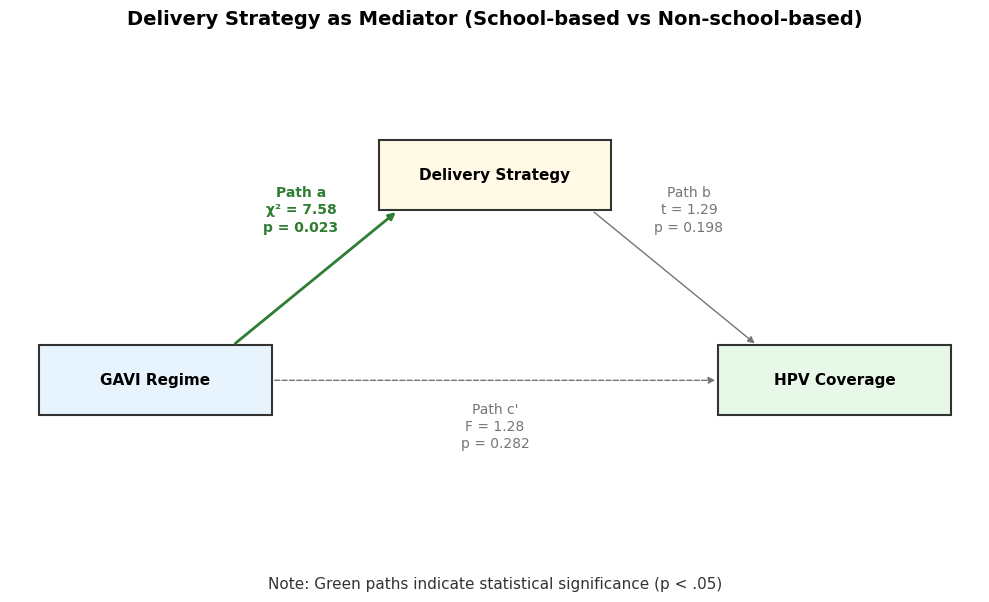

In [127]:
# Main execution - Traditional Statistical Tests
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Calculate statistics for delivery strategy model
delivery_stats = calculate_model_stats(df_analysis, 'M')

# Print summary of statistics
print("="*70)
print("DELIVERY STRATEGY MEDIATION - MODEL STATISTICS")
print("="*70)

print("\nPath a (χ²): {:.4f}, p = {:.4f}".format(delivery_stats['a_stat'], delivery_stats['a_p']))
print("Path b (t): {:.4f}, p = {:.4f}".format(delivery_stats['b_stat'], delivery_stats['b_p']))
print("Path c (F): {:.4f}, p = {:.4f}".format(delivery_stats['c_stat'], delivery_stats['c_p']))

print("\nMeans by GAVI Regime:")
print(delivery_stats['regime_means'])

print("\nMeans by Delivery Strategy:")
print("  0 = Non-school-based, 1 = School-based")
print(delivery_stats['mediator_means'])

# Draw the plot
draw_mediation(ax, 'Delivery Strategy', delivery_stats)
ax.set_title('Delivery Strategy as Mediator (School-based vs Non-school-based)', 
             fontsize=14, fontweight='bold', pad=45)

# Add note
fig.text(0.5, 0.01, 
         'Note: Green paths indicate statistical significance (p < .05)',
         ha='center', fontsize=11, color='#333')

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.show()